<h1>Prepare Environment</h1>

In [1]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import time

<h1>Loading dataset</h1>

In [4]:
DATA_DIR = './CamVid/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# Lets look at data we have
"""
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
"""
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'])

image, mask = dataset[5] # get some sample

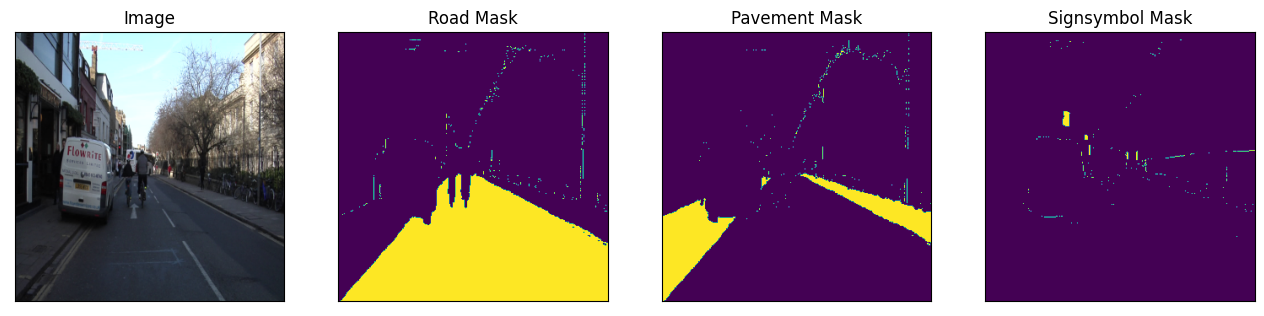

In [7]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

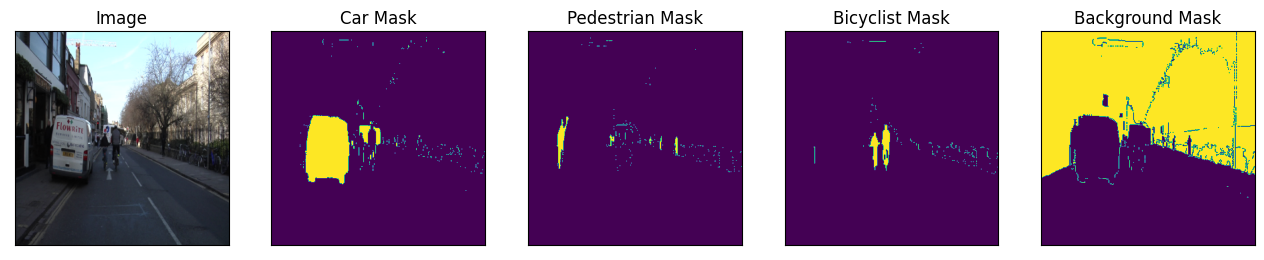

In [8]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Augmentation</h1>

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'], 
                  augmentation=get_training_augmentation())

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
image, mask = dataset[20] # get some sample

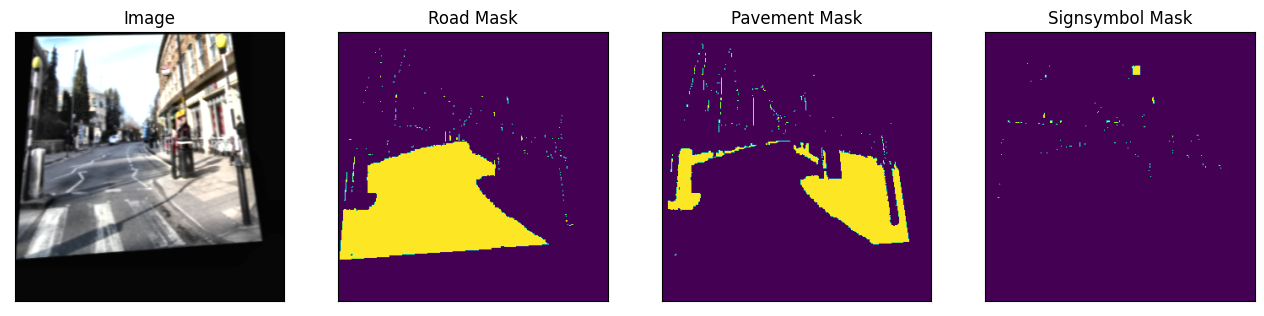

In [11]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

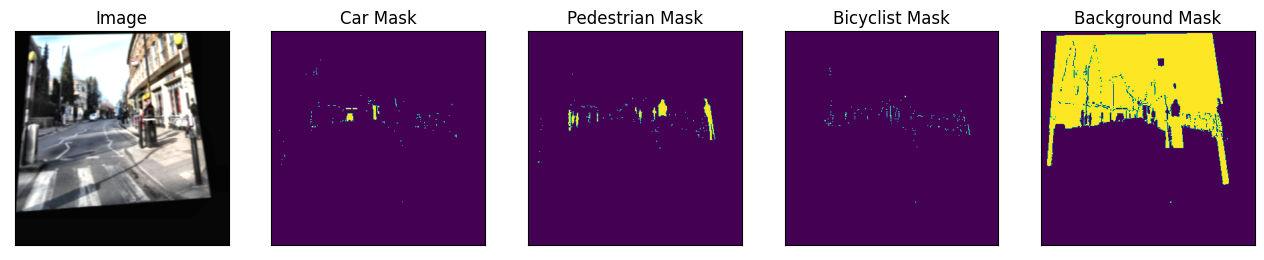

In [12]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Segmentation Model Training</h1>

In [13]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [14]:
BACKBONE = 'mobilenetv2'
BATCH_SIZE = 4
CLASSES = ['road', 'pavement', 'signsymbol','car', 'pedestrian', 'bicyclist']
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
2021-12-01 17:41:35.315733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 17:41:35.321207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 17:41:35.321552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01

In [16]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

In [17]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/mobilenetv2_Linknet.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [19]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/tmp/ipykernel_76628/1794659408.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250


2021-12-01 17:41:42.688214: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


91/91 [==============================] - 26s 199ms/step - loss: 0.9202 - iou_score: 0.0390 - f1-score: 0.0621 - val_loss: 0.8409 - val_iou_score: 0.1015 - val_f1-score: 0.1398 - lr: 1.0000e-04
Epoch 2/250
91/91 [==============================] - 17s 183ms/step - loss: 0.7725 - iou_score: 0.2316 - f1-score: 0.2918 - val_loss: 0.7409 - val_iou_score: 0.2561 - val_f1-score: 0.3024 - lr: 1.0000e-04
Epoch 3/250
91/91 [==============================] - 17s 183ms/step - loss: 0.7041 - iou_score: 0.3055 - f1-score: 0.3522 - val_loss: 0.6980 - val_iou_score: 0.2763 - val_f1-score: 0.3204 - lr: 1.0000e-04
Epoch 4/250
91/91 [==============================] - 17s 185ms/step - loss: 0.6717 - iou_score: 0.3585 - f1-score: 0.4208 - val_loss: 0.6344 - val_iou_score: 0.3770 - val_f1-score: 0.4344 - lr: 1.0000e-04
Epoch 5/250
91/91 [==============================] - 17s 185ms/step - loss: 0.6370 - iou_score: 0.3917 - f1-score: 0.4536 - val_loss: 0.6259 - val_iou_score: 0.3813 - val_f1-score: 0.4359 - lr

Epoch 40/250
91/91 [==============================] - 17s 190ms/step - loss: 0.4388 - iou_score: 0.5408 - f1-score: 0.6236 - val_loss: 0.4021 - val_iou_score: 0.5758 - val_f1-score: 0.6776 - lr: 5.0000e-05
Epoch 41/250
91/91 [==============================] - 18s 191ms/step - loss: 0.4332 - iou_score: 0.5437 - f1-score: 0.6286 - val_loss: 0.4014 - val_iou_score: 0.5757 - val_f1-score: 0.6769 - lr: 5.0000e-05
Epoch 42/250
91/91 [==============================] - 18s 192ms/step - loss: 0.4330 - iou_score: 0.5456 - f1-score: 0.6305 - val_loss: 0.3939 - val_iou_score: 0.5853 - val_f1-score: 0.6879 - lr: 5.0000e-05
Epoch 43/250
91/91 [==============================] - 17s 190ms/step - loss: 0.4375 - iou_score: 0.5421 - f1-score: 0.6259 - val_loss: 0.4060 - val_iou_score: 0.5730 - val_f1-score: 0.6736 - lr: 5.0000e-05
Epoch 44/250
91/91 [==============================] - 17s 186ms/step - loss: 0.4382 - iou_score: 0.5432 - f1-score: 0.6279 - val_loss: 0.4032 - val_iou_score: 0.5748 - val_f1-s

91/91 [==============================] - 17s 189ms/step - loss: 0.4251 - iou_score: 0.5512 - f1-score: 0.6434 - val_loss: 0.3832 - val_iou_score: 0.5905 - val_f1-score: 0.6925 - lr: 6.2500e-06
Epoch 78/250
91/91 [==============================] - 17s 189ms/step - loss: 0.4236 - iou_score: 0.5551 - f1-score: 0.6451 - val_loss: 0.3833 - val_iou_score: 0.5889 - val_f1-score: 0.6908 - lr: 6.2500e-06
Epoch 79/250
91/91 [==============================] - 17s 190ms/step - loss: 0.4200 - iou_score: 0.5561 - f1-score: 0.6458 - val_loss: 0.3846 - val_iou_score: 0.5885 - val_f1-score: 0.6906 - lr: 6.2500e-06
Epoch 80/250
91/91 [==============================] - ETA: 0s - loss: 0.4198 - iou_score: 0.5546 - f1-score: 0.6449
Epoch 00080: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
91/91 [==============================] - 17s 189ms/step - loss: 0.4198 - iou_score: 0.5546 - f1-score: 0.6449 - val_loss: 0.3843 - val_iou_score: 0.5892 - val_f1-score: 0.6913 - lr: 6.2500e-06
Epoch 8

91/91 [==============================] - 17s 188ms/step - loss: 0.4145 - iou_score: 0.5571 - f1-score: 0.6496 - val_loss: 0.3821 - val_iou_score: 0.5901 - val_f1-score: 0.6914 - lr: 9.7656e-08
Epoch 112/250
91/91 [==============================] - 17s 191ms/step - loss: 0.4128 - iou_score: 0.5619 - f1-score: 0.6537 - val_loss: 0.3824 - val_iou_score: 0.5902 - val_f1-score: 0.6915 - lr: 9.7656e-08
Epoch 113/250
91/91 [==============================] - 17s 190ms/step - loss: 0.4221 - iou_score: 0.5502 - f1-score: 0.6418 - val_loss: 0.3826 - val_iou_score: 0.5897 - val_f1-score: 0.6910 - lr: 9.7656e-08
Epoch 114/250
91/91 [==============================] - 17s 190ms/step - loss: 0.4171 - iou_score: 0.5560 - f1-score: 0.6492 - val_loss: 0.3827 - val_iou_score: 0.5901 - val_f1-score: 0.6914 - lr: 9.7656e-08
Epoch 115/250
91/91 [==============================] - ETA: 0s - loss: 0.4214 - iou_score: 0.5529 - f1-score: 0.6443
Epoch 00115: ReduceLROnPlateau reducing learning rate to 4.8828123766

<h1>Model Evaluation</h1>

In [20]:
print('Time training:{} (s)'.format(time_training))

Time training:2178.9466416835785 (s)


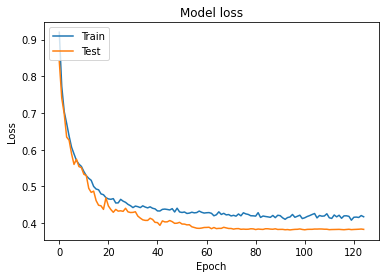

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

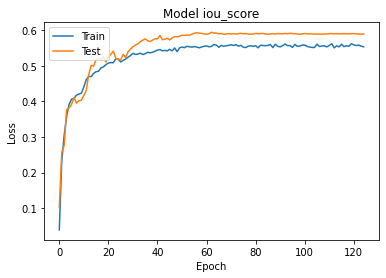

In [22]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [24]:
# load best weights
model.load_weights('./checkpoint/mobilenetv2_Linknet.h5')

In [25]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/tmp/ipykernel_76628/2477453485.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores  = model.evaluate_generator(test_dataloader)


Loss:0.46598
mean iou_score:0.50927
mean f1-score:0.58436


In [26]:
df = pd.DataFrame({'backbone':[BACKBONE],'model':['Linknet'],'Time_training':[time_training],
                   'loss':[scores[0]],'Iou_score':[scores[1]]})

In [27]:
df

,backbone,model,Time_training,loss,Iou_score
0,mobilenetv2,Linknet,2178.946642,0.465985,0.509271


In [28]:
data = pd.read_excel('Evaluation_model.xlsx')
data = data[['backbone','model','Time_training','loss','Iou_score']]
data

,backbone,model,Time_training,loss,Iou_score
0,efficientnetb3,Linknet,3015.350176,0.447298,0.521443
1,inceptionv3,Linknet,2318.630428,0.455518,0.515724
2,resnet50,Linknet,2392.091974,0.442126,0.526585
3,vgg16,Linknet,3602.742987,0.486155,0.494493
4,resnet50,FPN,5574.922504,0.429762,0.536333
5,vgg16,FPN,4756.101279,0.424975,0.544290
6,vgg16,Unet,4716.292528,0.450795,0.524129
7,resnet50,Unet,2754.380667,0.436002,0.532806
8,mobilenetv2,Unet,2111.109734,0.441323,0.526182
9,mobilenetv2,FPN,3336.091649,0.434233,0.532188


In [29]:
df = pd.concat([df,data],axis=0)
df

,backbone,model,Time_training,loss,Iou_score
0,mobilenetv2,Linknet,2178.946642,0.465985,0.509271
0,efficientnetb3,Linknet,3015.350176,0.447298,0.521443
1,inceptionv3,Linknet,2318.630428,0.455518,0.515724
2,resnet50,Linknet,2392.091974,0.442126,0.526585
3,vgg16,Linknet,3602.742987,0.486155,0.494493
4,resnet50,FPN,5574.922504,0.429762,0.536333
5,vgg16,FPN,4756.101279,0.424975,0.544290
6,vgg16,Unet,4716.292528,0.450795,0.524129
7,resnet50,Unet,2754.380667,0.436002,0.532806
8,mobilenetv2,Unet,2111.109734,0.441323,0.526182


In [30]:
df.to_excel('Evaluation_model.xlsx')

<h1>Evaluation on Test</h1>

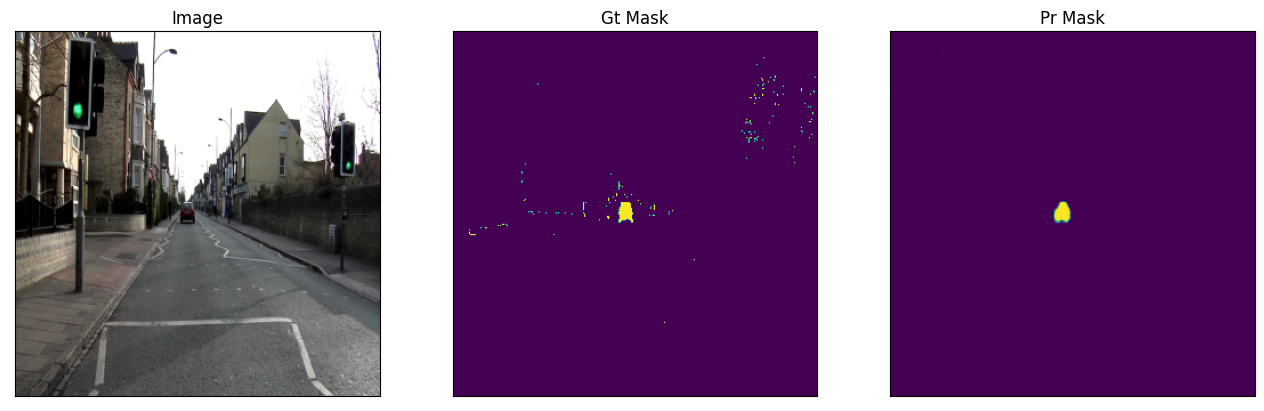

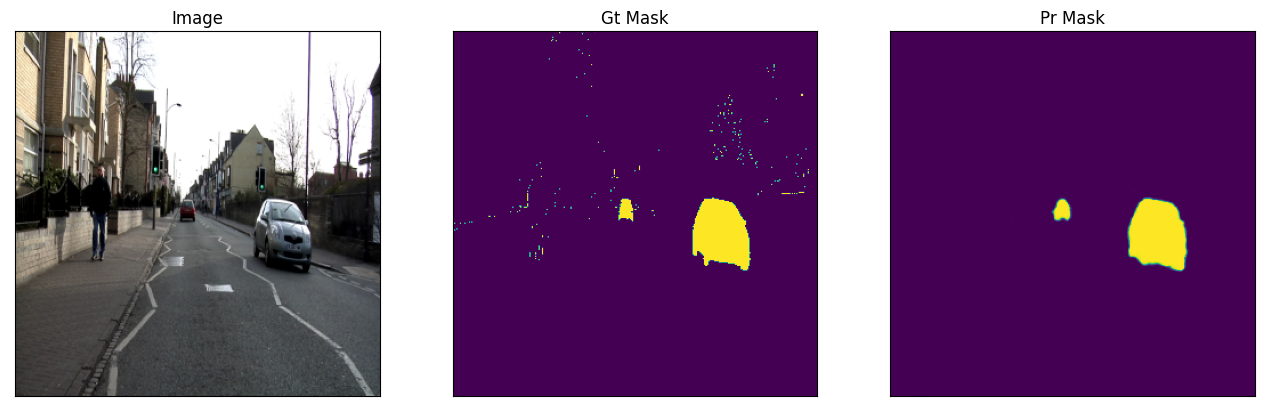

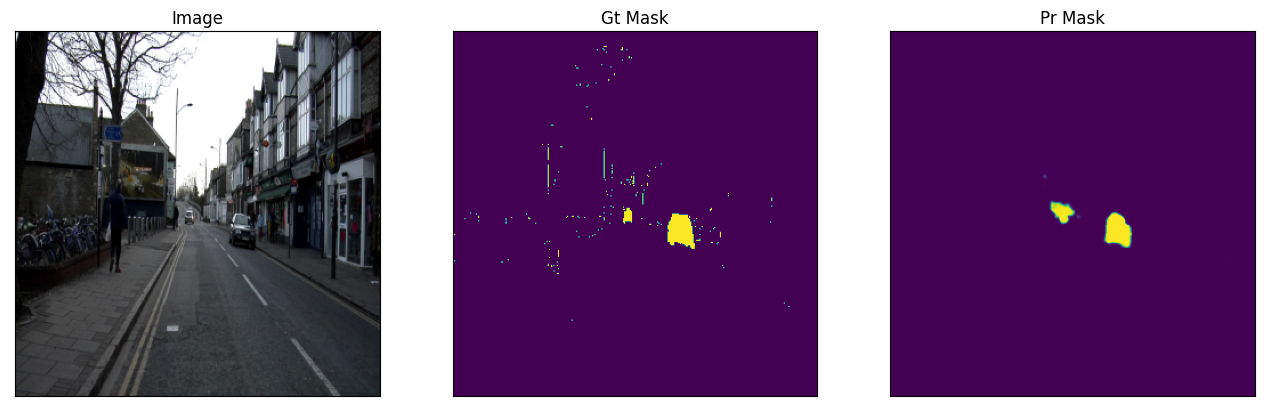

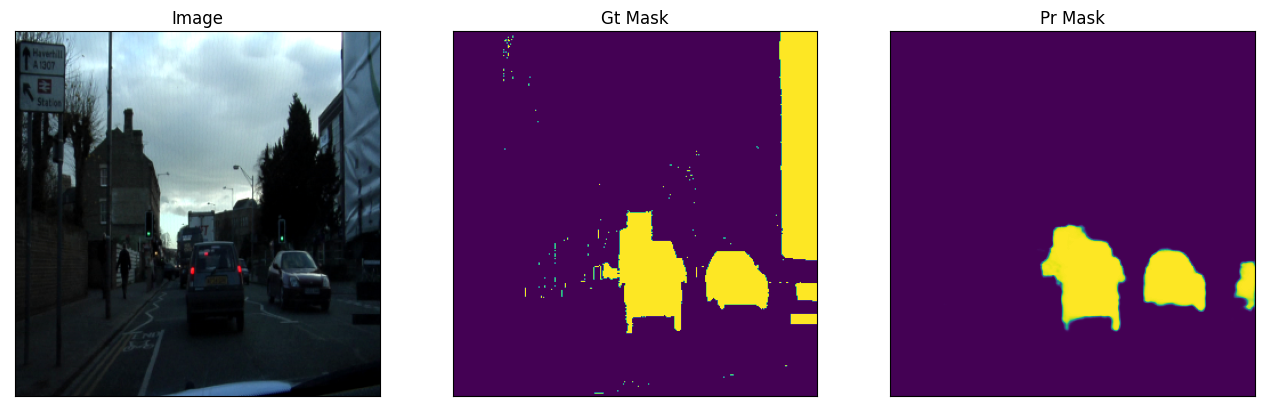

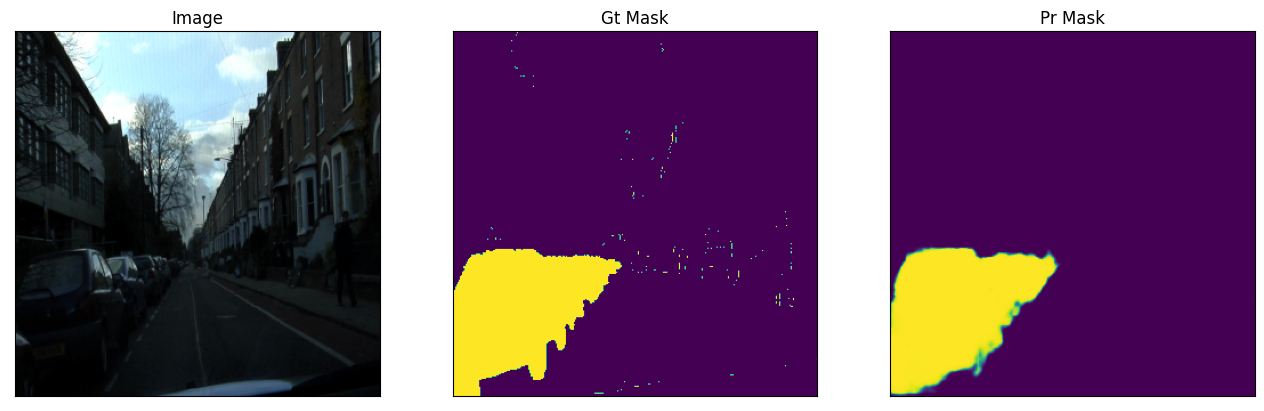

In [31]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,3].squeeze(),
        pr_mask=pr_mask[...,3].squeeze(),
    )